In [ ]:
import argparse
import os

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from imutils import paths
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.callbacks import (
    EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical


In [ ]:
def load(imagePaths, fold, img_width, img_height):
    train_labels, test_labels = [], []
    train_data, test_data = [], []

    for imagePath in imagePaths:
        path_parts = imagePath.split(os.path.sep)
        # extract the split
        train_test = path_parts[-3][-1]
        # extract the class label from the filename
        label = path_parts[-2]
        # load the image, swap color channels, and resize it to be a fixed
        # 224x224 pixels while ignoring aspect ratio
        image = cv2.imread(imagePath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (img_width, img_height))

        # update the data and labels lists, respectively
        if train_test == str(fold):
            test_labels.append(label)
            test_data.append(image)
            # test_files.append(path_parts[-1])
        else:
            train_labels.append(label)
            train_data.append(image)
    '''
    Converting the list to numpy array with normalizing the pixel values
    '''
    train_data = np.array(train_data) / 255.0
    test_data = np.array(test_data) / 255.0
    train_labels_text = np.array(train_labels)
    test_labels_text = np.array(test_labels)

    return train_data, train_labels_text, test_data, test_labels_text

In [ ]:
def fix_layers(model, num_flex_layers: int = 1):
    """
    Receives a model and freezes all layers but the last num_flex_layers ones.

    Arguments:
        model {tensorflow.python.keras.engine.training.Model} -- model

    Keyword Arguments:
        num_flex_layers {int} -- [Number of trainable layers] (default: {1})

    Returns:
        Model -- updated model
    """
    num_layers = len(model.layers)
    for ind, layer in enumerate(model.layers):
        if ind < num_layers - num_flex_layers:
            layer.trainable = False

    return model

In [ ]:
from sklearn.metrics import balanced_accuracy_score
from tensorflow.keras.callbacks import Callback

class Metrics(Callback):

    def __init__(self, valid_data, model):
        super(Metrics, self).__init__()
        self.valid_data = valid_data
        self._data = []
        self.model = model

    def on_epoch_end(self, epoch, logs=None):
        # if epoch:
        #     for i in range(1):  # len(self.valid_data)):
        x_test_batch, y_test_batch = self.valid_data

        y_predict = np.asarray(self.model.predict(x_test_batch))

        y_val = np.argmax(y_test_batch, axis=1)
        y_predict = np.argmax(y_predict, axis=1)
        self._data.append(
            {
                'val_balanced': balanced_accuracy_score(y_val, y_predict),
            }
        )
        print(f'Balanced accuracy is: {self._data[-1]}')
        return

    def get_data(self):
        return self._data

In [ ]:
from tensorflow.keras.applications import (
    VGG16, MobileNetV2, NASNetMobile, ResNet50
)
from tensorflow.keras.layers import (
    AveragePooling2D,
    Dense,
    Dropout,
    Flatten,
    Input,
    BatchNormalization,
    ReLU,
    LeakyReLU
)
from sklearn.metrics import balanced_accuracy_score
from tensorflow.keras.callbacks import Callback
import tensorflow.keras as K
from tensorflow.keras.callbacks import (
    EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
)
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def get_model(
        input_size: tuple = (224, 224, 3),
        hidden_size: int = 64,
        dropout: float = 0.5,
        num_classes: int = 3,
        trainable_layers: int = 1,
        log_softmax: bool = False,
        mc_dropout: bool = False,
        **kwargs
    ):
        # act_fn = tf.nn.softmax if not log_softmax else tf.nn.log_softmax
        act_fn = tf.nn.softmax

        # load the VGG16 network, ensuring the head FC layer sets are left off
        baseModel = VGG16(
            weights="imagenet",
            include_top=False,
            input_tensor=Input(shape=input_size)
        )
        # construct the head of the model that will be placed on top of the
        # the base model
        headModel = baseModel.output
        headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
        headModel = Flatten(name="flatten")(headModel)
        headModel = Dense(hidden_size)(headModel)
        headModel = BatchNormalization()(headModel)
        headModel = ReLU()(headModel)
        headModel = (
            Dropout(dropout)(headModel, training=True)
            if mc_dropout else Dropout(dropout)(headModel)
        )
        headModel = Dense(num_classes, activation=act_fn)(headModel)

        # place the head FC model on top of the base model
        model = Model(inputs=baseModel.input, outputs=headModel)

        model = fix_layers(model, num_flex_layers=trainable_layers + 8)

        return model

def get_resnet50_model(
  input_size: tuple = (224, 224, 3),
  hidden_size: int = 64,
  dropout: float = 0.5,
  num_classes: int = 3,
  trainable_layers: int = 3,
  log_softmax: bool = True,
  mc_dropout: bool = False,
  **kwargs
):
  act_fn = tf.nn.softmax if not log_softmax else tf.nn.log_softmax

  # load the VGG16 network, ensuring the head FC layer sets are left off
  baseModel = ResNet50(
      weights="imagenet",
      include_top=False,
      input_tensor=Input(shape=input_size)
  )
  # construct the head of the model that will be placed on top of the
  # the base model
  headModel = baseModel.output
  headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
  headModel = Flatten(name="flatten")(headModel)
  headModel = Dense(hidden_size)(headModel)
  headModel = BatchNormalization()(headModel)
  headModel = ReLU()(headModel)
  headModel = (
      Dropout(dropout)(headModel, training=True)
      if mc_dropout else Dropout(dropout)(headModel)
  )
  headModel = Dense(num_classes, activation=act_fn)(headModel)

  # place the head FC model on top of the base model
  model = Model(inputs=baseModel.input, outputs=headModel)

  model = fix_layers(model, num_flex_layers=trainable_layers + 8)

  return model

  def get_cam_model(
    input_size: tuple = (224, 224, 3),
    num_classes: int = 3,
    trainable_layers: int = 1,
    dropout: float = 0.5,
    log_softmax: bool = False,
    mc_dropout: bool = False,
    *args,
    **kwargs
):
    """
    Get a VGG model that supports class activation maps w/o guided gradients

    Keyword Arguments:
        input_size {tuple} -- [Image size] (default: {(224, 224, 3)})
        num_classes {int} -- [Number of output classes] (default: {3})
        trainable_layers {int} -- [Number of trainable layers] (default: {3})

    Returns:
        tensorflow.keras.models object
    """
    act_fn = tf.nn.softmax if not log_softmax else tf.nn.log_softmax

    # load the VGG16 network, ensuring the head FC layer sets are left off
    baseModel = VGG16(
        weights="imagenet",
        include_top=False,
        input_tensor=Input(shape=input_size)
    )
    headModel = baseModel.output
    headModel = global_average_pooling(headModel)
    headModel = (
        Dropout(dropout)(headModel, training=True)
        if mc_dropout else Dropout(dropout)(headModel)
    )
    headModel = Dense(num_classes, activation=act_fn)(headModel)

    model = Model(inputs=baseModel.input, outputs=headModel)
    model = fix_layers(model, num_flex_layers=trainable_layers + 2)

    return model

In [ ]:
# import tarfile

# # Extract the dataset
# with tarfile.open("/content/drive/MyDrive/capstone/fold4.tar.gz", "r:gz") as tar:
#     tar.extractall("/content/drive/MyDrive/capstone/")

In [ ]:
# Data is already preprocessed and save as numpy array
import numpy as np

trainX = np.load('/content/drive/MyDrive/capstone/fold4/train_data.npy')
trainY = np.load('/content/drive/MyDrive/capstone/fold4/train_labels_text.npy')
testX = np.load('/content/drive/MyDrive/capstone/fold4/test_data.npy')
testY = np.load('/content/drive/MyDrive/capstone/fold4/test_labels_text.npy')

In [ ]:
# # perform one-hot encoding on the labels
lb = LabelBinarizer()
lb.fit(trainY)

train_labels = lb.transform(trainY)
test_labels = lb.transform(testY)

In [ ]:
trainX = trainX
trainY = train_labels
testX = testX
testY = test_labels

In [ ]:
# initialize the training data augmentation object
trainAug = ImageDataGenerator(
    rotation_range=10,
    fill_mode='nearest',
    horizontal_flip=True,
    vertical_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

In [ ]:
model = get_resnet50_model()

In [ ]:
# Define callbacks
earlyStopping = EarlyStopping(
    monitor='loss',
    patience=20,
    verbose=1,
    mode='min',
    restore_best_weights=True
)

MODEL_DIR = "/content/drive/MyDrive/capstone/trained_resnet_models/fold4"
mcp_save = ModelCheckpoint(
    os.path.join(MODEL_DIR, 'best_weights'),
    save_best_only=True,
    monitor='accuracy',
    mode='max',
    verbose=1
)

reduce_lr_loss = ReduceLROnPlateau(
    monitor='loss',
    factor=0.7,
    patience=7,
    verbose=1,
    min_delta=1e-4,
    mode='min'
)

metrics = Metrics((testX, testY), model)

In [ ]:
LR = 1e-4
EPOCHS = 30
LOG_SOFTMAX = False
BATCH_SIZE = 8

initial_learning_rate = 1e-4
final_learning_rate = 0.0001
learning_rate_decay_factor = (final_learning_rate / initial_learning_rate)**(1/EPOCHS)
steps_per_epoch = int(len(trainX)/BATCH_SIZE)


# opt = Adam(lr=LR, decay=LR / EPOCHS)
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=initial_learning_rate,
    decay_steps=steps_per_epoch,
    decay_rate=learning_rate_decay_factor,
    staircase=True
    )

optimizer = Adam(learning_rate = lr_schedule)
# loss = (
#     tf.keras.losses.CategoricalCrossentropy() if not LOG_SOFTMAX else (
#         lambda labels, targets: tf.reduce_mean(
#             tf.reduce_sum(
#                 -1 * tf.math.multiply(tf.cast(labels, tf.float32), targets),
#                 axis=1
#             )
#         )
#     )
# )
loss = tf.keras.losses.CategoricalCrossentropy()
model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])

print(f'Model has {model.count_params()} parameters')
print(f'Model summary {model.summary()}')

In [ ]:
train_loss = []
train_accuracy = []
val_loss = []
val_accuracy = []
# for epoch in range(EPOCHS):
# Training step
H = model.fit(
    trainAug.flow(trainX, trainY, batch_size=BATCH_SIZE),
    steps_per_epoch=len(trainX) // BATCH_SIZE,
    validation_data=(testX, testY),
    validation_steps=len(testX) // BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[earlyStopping, mcp_save, reduce_lr_loss]
)

Epoch 1/30
311/311 [==============================] - ETA: 0s - loss: 0.6121 - accuracy: 0.0536


Epoch 1: accuracy improved from -inf to 0.05361, saving model to /content/drive/MyDrive/capstone/trained_resnet_models/fold4/best_weights


311/311 [==============================] - 54s 158ms/step - loss: 0.6121 - accuracy: 0.0536 - val_loss: 1.5339 - val_accuracy: 0.1332 - lr: 1.0000e-04
Epoch 2/30
311/311 [==============================] - ETA: 0s - loss: 0.6211 - accuracy: 0.0593
Epoch 2: accuracy improved from 0.05361 to 0.05925, saving model to /content/drive/MyDrive/capstone/trained_resnet_models/fold4/best_weights


311/311 [==============================] - 45s 143ms/step - loss: 0.6211 - accuracy: 0.0593 - lr: 1.0000e-04
Epoch 3/30
311/311 [==============================] - ETA: 0s - loss: 0.6064 - accuracy: 0.0524
Epoch 3: accuracy did not improve from 0.05925
311/311 [==============================] - 25s 80ms/step - loss: 0.6064 - accuracy: 0.0524 - lr: 1.0000e-04
Epoch 4/30
311/311 [==============================] - ETA: 0s - loss: 0.5873 - accuracy: 0.0496
Epoch 4: accuracy did not improve from 0.05925
311/311 [==============================] - 25s 80ms/step - loss: 0.5873 - accuracy: 0.0496 - lr: 1.0000e-04
Epoch 5/30
311/311 [==============================] - ETA: 0s - loss: 0.6043 - accuracy: 0.0564
Epoch 5: accuracy did not improve from 0.05925
311/311 [==============================] - 25s 80ms/step - loss: 0.6043 - accuracy: 0.0564 - lr: 1.0000e-04
Epoch 6/30
311/311 [==============================] - ETA: 0s - loss: 0.6093 - accuracy: 0.0572
Epoch 6: accuracy did not improve from 0.0

311/311 [==============================] - 44s 143ms/step - loss: 0.6159 - accuracy: 0.0713 - lr: 1.0000e-04
Epoch 10/30
311/311 [==============================] - ETA: 0s - loss: 0.5917 - accuracy: 0.0496
Epoch 10: accuracy did not improve from 0.07134
311/311 [==============================] - 25s 81ms/step - loss: 0.5917 - accuracy: 0.0496 - lr: 1.0000e-04
Epoch 11/30
311/311 [==============================] - ETA: 0s - loss: 0.5799 - accuracy: 0.0564
Epoch 11: accuracy did not improve from 0.07134
311/311 [==============================] - 25s 80ms/step - loss: 0.5799 - accuracy: 0.0564 - lr: 1.0000e-04
Epoch 12/30
311/311 [==============================] - ETA: 0s - loss: 0.5901 - accuracy: 0.0560
Epoch 12: accuracy did not improve from 0.07134
311/311 [==============================] - 25s 79ms/step - loss: 0.5901 - accuracy: 0.0560 - lr: 1.0000e-04
Epoch 13/30
311/311 [==============================] - ETA: 0s - loss: 0.5764 - accuracy: 0.0512
Epoch 13: accuracy did not improve 

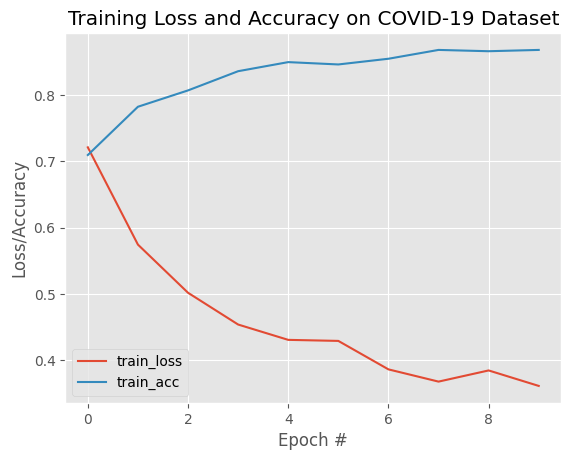

In [ ]:
N = EPOCHS
plt.style.use('ggplot')
plt.figure()
plt.plot(np.arange(0, N), H.history['loss'], label='train_loss')
# plt.plot(np.arange(0, N), H.history['val_loss'], label='val_loss')
plt.plot(np.arange(0, N), H.history['accuracy'], label='train_acc')
# plt.plot(np.arange(0, N), H.history['val_accuracy'], label='val_acc')
plt.title('Training Loss and Accuracy on COVID-19 Dataset')
plt.xlabel('Epoch #')
plt.ylabel('Loss/Accuracy')
plt.legend(loc='lower left')
plt.savefig(os.path.join(MODEL_DIR, 'loss.png'))

In [ ]:
lb.classes_

20/20 [==============================] - 9s 248ms/step


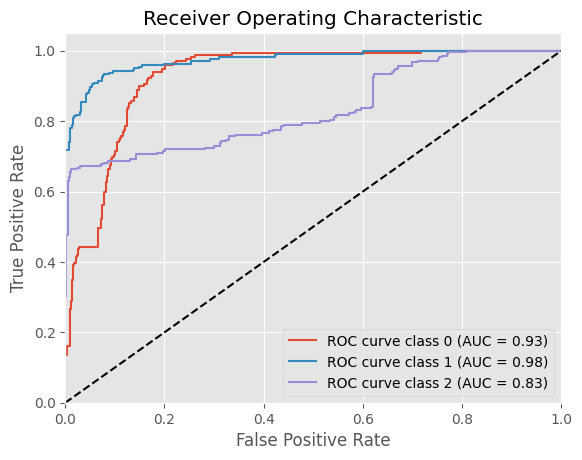

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

testY_binary = label_binarize(testY, classes=lb.classes_)  # Replace [0, 1, 2] with your actual label classes

# Get predicted probabilities for test data
y_pred_prob = model.predict(testX)

# Compute false positive rate, true positive rate, and thresholds
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(testY_binary.shape[1]):
    fpr[i], tpr[i], _ = roc_curve(testY_binary[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure()
for i in range(testY_binary.shape[1]):
    plt.plot(fpr[i], tpr[i], label='ROC curve class {} (AUC = {:.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [ ]:
print('Evaluating network...')
predIdxs = model.predict(testX, batch_size=BATCH_SIZE)
predIdxs = np.argmax(predIdxs, axis=1)
target_names = lb.classes_.astype(str)

print('classification report sklearn:')
print(
    classification_report(testY.argmax(axis=1),
                          predIdxs,
                          target_names=lb.classes_)
    )

# compute the confusion matrix and and use it to derive the raw
# accuracy, sensitivity, and specificity
print('confusion matrix:')
cm = confusion_matrix(testY.argmax(axis=1), predIdxs)
# show the confusion matrix, accuracy, sensitivity, and specificity
print(cm)